# Manipulations sur le pré-traitement des données EEG

L'objectif de ce cahier est d'expérimenter sur le pré-traitement effectué sur les données EEG fournies.

Nous importons tout d'abord le module MNE pour manipuler les données.
Nous importons également le module matplotlib.pyplot pour les affichages.

In [1]:
import mne
import matplotlib.pyplot as plt

Nous lisons ensuite les données brutes et celles pré-traitées (ici S10_NF1).

In [2]:
raw = mne.io.read_raw_brainvision('../EEG_Data/raw/S10_NF1.vhdr')
pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')

Extracting parameters from ../EEG_Data/raw/S10_NF1.vhdr...
Setting channel info structure...
Extracting parameters from ../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr...
Setting channel info structure...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}


<ipython-input-2-f44402bd3d6d>:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')
<ipython-input-2-f44402bd3d6d>:2: DeprecationWarning: The `montage` parameter from `read_raw_brainvision` is deprecated and will be removed  in version 0.20. Use  raw.set_montage(montage) instead.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')


Les avertissements ci-dessus ne sont pas inquiétants. 

Nous affichons cependant les informations afin de s'assurer que tout est normal.

In [3]:
print(raw.info)
print(pp.info)
print(raw.ch_names)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

On note tout d'abord une forte diminution de la fréquence d'échantillonage, ce qui permet d'effacer une partie du bruit. On note également l'ajout d'un champ 'dig' dans les données pré-traitées.

On en extrait les données, que l'on affiche pour s'assurer que tout fonctionne bien.

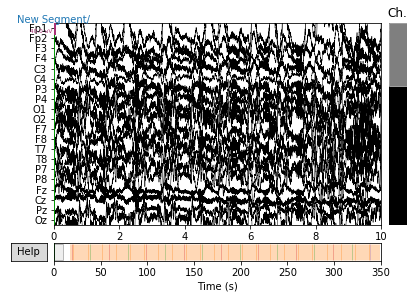

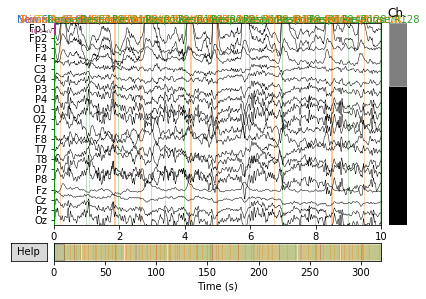

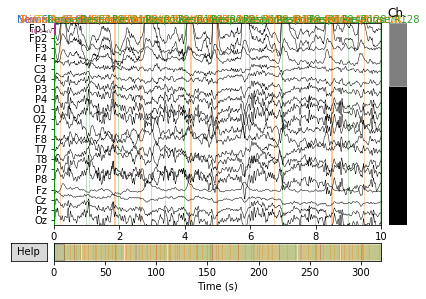

In [4]:
#time_interval = [20,50]
#raw_start_time, raw_stop_time = raw.time_as_index(time_interval)
#pp_start_time, pp_stop_time = pp.time_as_index(time_interval)

raw_data, raw_time = raw[:, :]
pp_data, pp_time = pp[:, :]

raw.plot()
pp.plot()

Nous nous intéresserons par la suite à la première électrode, étiquetée "Ep1".

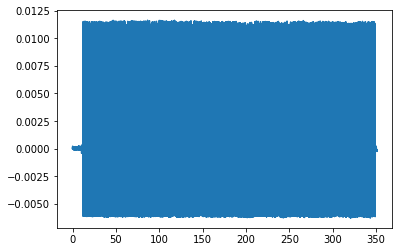

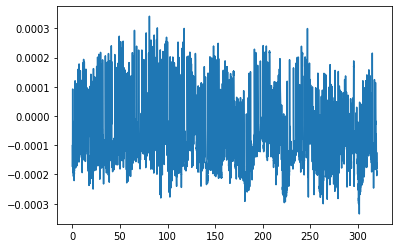

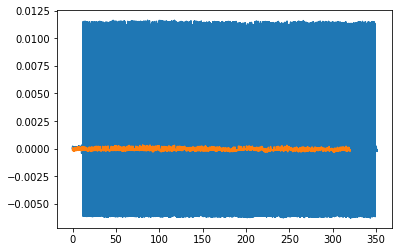

In [5]:
ep1_raw_data = raw_data[1,:]
ep1_pp_data = pp_data[1,:]

plt.plot(raw_time,ep1_raw_data)
plt.show()
plt.plot(pp_time, ep1_pp_data)
plt.show()

plt.plot(raw_time,ep1_raw_data)
plt.plot(pp_time, ep1_pp_data)
plt.show()

## Passage des données brutes aux pré-traitées

Nous allons ici retracer les étapes du pré-traitement tel que décrit dans le fichier "readme.rtf".

### Correction automatique de gradient

La première étape est de corriger l'artéfact de gradient, lié aux légères variations dans les gradients du champ magnétique de l'IRM, à une désynchronisation de l'EEG et de l'IRM, et à de léger mouvements de la tête.

Cela se fait à l'aide des marqueurs 'Response' du fichier .vmrk.

In [6]:
annotations = mne.read_annotations('../EEG_Data/raw/S10_NF1.vmrk')
response_annotations = [annotation for annotation in annotations if annotation['description'] == "Response/R128"]
print(len(response_annotations))

Finding 'sfreq' from header file: ../EEG_Data/raw/S10_NF1.vhdr
332


Ces marqueurs sont tous situés sur une trame unique (0.2 ms à 5kHz).

In [7]:
artifact_duration = response_annotations[0]['duration']
print(artifact_duration)

0.0002


In [8]:
for annotation in response_annotations:
    assert(annotation['duration'] == artifact_duration)

Vérifions si la position de ces marqueurs est périodique.

In [9]:
marker_period = response_annotations[1]['onset'] - response_annotations[0]['onset']

for i in range(len(response_annotations) - 1):
    if(response_annotations[i+1]['onset']-response_annotations[i]['onset'] != marker_period):
        print(response_annotations[i+1]['onset']-response_annotations[i]['onset'] - marker_period)

7.105427357601002e-15


Avec une fréquence d'échantillonnage à 5000 Hz, cette variation est négligeable (moins d'une trame). Nous allons donc considérer l'artéfact de gradient typique comme un "signal moyen" de ceux pris entre deux marqueurs.

Cela revient à faire l'hypothèse que le signal d'intérêt est de moyenne nulle (ou négligeable).

Nous allons dans un premier temps simplement retrancher au signal la moyenne glissante sur 21 intervalles de marqueurs. Nous allons utiliser la méthode cumsum du module np (https://stackoverflow.com/questions/13728392/moving-average-or-running-mean). 

In [10]:
import numpy as np

def cumsum_sma(array, period):
    ret = np.cumsum(array, dtype=float)
    ret[period:] = ret[period:] - ret[:-period]
    return ret[period - 1:] / period

def cumulative_interval_average(array, window_size, interval_size):
    averaged_array = []
    for i in range(window_size, len(array)):
        averaged_array.append(np.mean(array[i-window_size:i+1:interval_size]))
    return np.array(averaged_array)

sma_window_time_size = 21*marker_period
sma_window_frame_size = raw.time_as_index([0, sma_window_time_size])[1]
interval_size = raw.time_as_index([0, marker_period])[1]

print(interval_size)

#ep1_raw_averaged_raw_data = cumsum_sma(ep1_raw_data, sma_window_frame_size)
ep1_raw_averaged_raw_data = cumulative_interval_average(ep1_raw_data, sma_window_frame_size, interval_size)

5000


Nous complétons les bords par des 0 pour retrouver une taille normale.

In [11]:
print(ep1_raw_averaged_raw_data.shape)
print(ep1_raw_data.shape)

#size_diff = len(ep1_raw_data) - len(ep1_raw_averaged_raw_data)
v1_time = raw_time[sma_window_frame_size:]
#ep1_averaged_raw_data = np.concatenate([[0]*(size_diff//2), [0], ep1_raw_averaged_raw_data, [0]*(size_diff//2)])
ep1_averaged_raw_data = ep1_raw_averaged_raw_data

assert(ep1_averaged_raw_data.shape == v1_time.shape)


(1649500,)
(1754500,)


Nous faisons enfin la soustraction point par point.

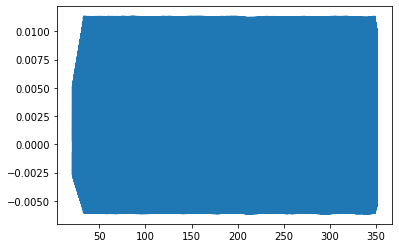

In [12]:
ep1_v1_pp_data = ep1_raw_data[sma_window_frame_size:] - ep1_averaged_raw_data

#plt.plot(raw_time, ep1_v1_pp_data)
plt.plot(v1_time, ep1_averaged_raw_data)
plt.show()

[221.     221.0002 221.0004 ... 240.9994 240.9996 240.9998]


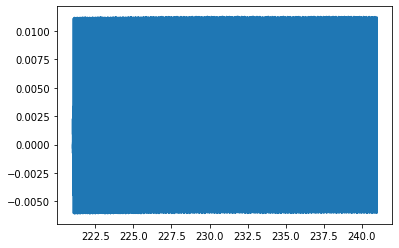

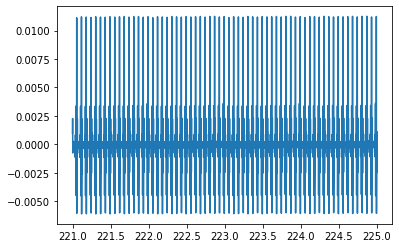

In [13]:
print(v1_time[1000000:1100000])
plt.plot(v1_time[1000000:1100000], ep1_averaged_raw_data[1000000:1100000])
plt.show()
plt.plot(v1_time[1000000:1020000], ep1_averaged_raw_data[1000000:1020000])#2sec

Nous créons donc une fonction de soustraction de cet artefact, pour réutilisation.

In [14]:
def get_gradient_artifact_marker_period(annotations):
    response_annotations = [annotation for annotation in annotations if annotation['description'] == "Response/R128"]
    
    #Safety check
    artifact_duration = response_annotations[0]['duration']
    for annotation in response_annotations:
        assert(annotation['duration'] == artifact_duration)
    
    marker_period = response_annotations[1]['onset'] - response_annotations[0]['onset']
    return marker_period

def clean_gradient(signal, time, averaging_size, marker_period):
    """
    Cleans a signal from the gradient artifact.
    ---
    Inputs:
        - signal: 1D float array. The signal as a numerical array.
        - time: 1D float array. The time corresponding to the input signal.
        - averaging_size: int. The number of intervals on which the gradient template is averaged.
        - marker_period: float. The duration (in seconds) between two marker gradients. Periodicity is required.
    ---
    Outputs:
        - cleaned_signal: 1D float array. The signal cleaned from gradient artifact.
        - cleaned_time : 1D float array. The time corresponding to the cleaned signal. 
                Basically the input time from the moment when there is enough data to average.
    """
    sma_window_time_size = averaging_size*marker_period
    sma_window_frame_size = raw.time_as_index([0, sma_window_time_size])[1]
    interval_size = raw.time_as_index([0, marker_period])[1]
    
    averaged_signal = cumulative_interval_average(signal, sma_window_frame_size, interval_size)
    
    cleaned_signal = signal[sma_window_frame_size:] - averaged_signal
    cleaned_time = raw_time[sma_window_frame_size:]
    
    return cleaned_signal, cleaned_time    
    

### Sous-échantillonnage

Nous pouvons ensuite faire un sous-échantillonnage du signal, à 200 Hz, à l'aide de la méthode resample du module scipy.signal.

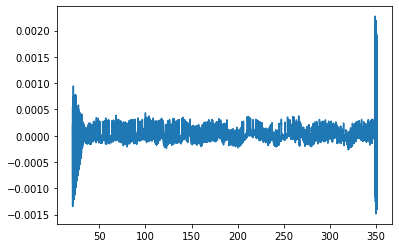

[350.4   350.405 350.41  350.415 350.42  350.425 350.43  350.435 350.44
 350.445 350.45  350.455 350.46  350.465 350.47  350.475 350.48  350.485
 350.49  350.495 350.5   350.505 350.51  350.515 350.52  350.525 350.53
 350.535 350.54  350.545 350.55  350.555 350.56  350.565 350.57  350.575
 350.58  350.585 350.59  350.595 350.6   350.605 350.61  350.615 350.62
 350.625 350.63  350.635 350.64  350.645 350.65  350.655 350.66  350.665
 350.67  350.675 350.68  350.685 350.69  350.695 350.7   350.705 350.71
 350.715 350.72  350.725 350.73  350.735 350.74  350.745 350.75  350.755
 350.76  350.765 350.77  350.775 350.78  350.785 350.79  350.795 350.8
 350.805 350.81  350.815 350.82  350.825 350.83  350.835 350.84  350.845
 350.85  350.855 350.86  350.865 350.87  350.875 350.88  350.885 350.89
 350.895]


In [15]:
from scipy import signal

samples_amount = len(ep1_v1_pp_data)//25
ep1_v2_pp_data = signal.resample(ep1_v1_pp_data, samples_amount)
resampled_time = v1_time[::25]

plt.plot(resampled_time, ep1_v2_pp_data)
plt.show()
print(resampled_time[-100:])

Nous définissons à nouveau la fonction associée:

In [16]:
def undersample(full_signal, time, frequency, diminution_factor=25):
    """
    Undersamples a signal.
    ---
    Inputs:
        - full_signal: 1D float array. The numerical values of the signal to undersample.
        - time: 1D float_array. The time association to the undersampled signal.
        - diminution_factor: int. The factor between the amounts of samples after and before treatment.
    ---
    Outputs:
        - undersampled_signal: 1D float array. The numerical values of the undersampled signal.
        - undersampled_time: 1D float_array. The time association to the undersampled signal.
    """
    samples_amount = len(full_signal)//diminution_factor
    undersampled_signal = signal.resample(full_signal, samples_amount)
    #undersampled_time = signal.resample(time, samples_amount)
    undersampled_time = time[::diminution_factor]
    
    return undersampled_signal,undersampled_time, frequency/diminution_factor

### Filtre passe-bas

Nous appliquons ensuite un filtre passe-bas à réponse impulsionnelle finie de 50 Hz, les fréquences supérieures étant considérées comme du bruit.

In [17]:
sample_rate = 200

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 50

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
ep1_v3_pp_data = signal.lfilter(taps, 1.0, ep1_v2_pp_data)

Nous affichons ensuite le signal obtenu, ici en orange, comparé au signal précédent, en bleu.

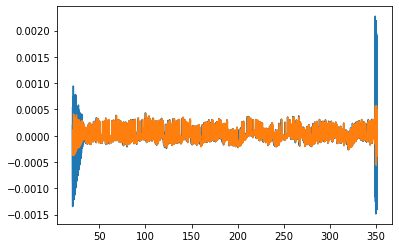

[ 21.     21.005  21.01  ... 350.885 350.89  350.895]


In [18]:
plt.plot(resampled_time, ep1_v2_pp_data)
plt.plot(resampled_time, ep1_v3_pp_data)
plt.show()
print(resampled_time)

Nous définissons encore une fois la fonction associée.

In [19]:
def low_pass_filter(full_signal, sample_rate=200, transition_width=5, ripple_db=60.0,cutoff_hz=50):
    """
    TODO: DOC
    """
    nyq_rate = sample_rate / 2.0
    width = 5.0/nyq_rate
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    low_passed_signal = signal.lfilter(taps, 1.0, full_signal)
    
    return low_passed_signal

## Correction de l'artefact de pouls

Nous nous attachons d'abord à récupérer l'électro-cardiogramme à travers l'électrode "ECG".

In [20]:
print(raw.info)
print(raw.ch_names)
ecg_channel_index = raw.ch_names.index('ECG')
print(ecg_channel_index)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

[0.000000e+00 2.000000e-04 4.000000e-04 ... 3.508994e+02 3.508996e+02
 3.508998e+02]


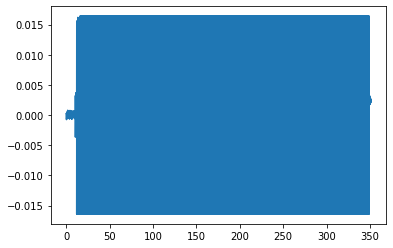

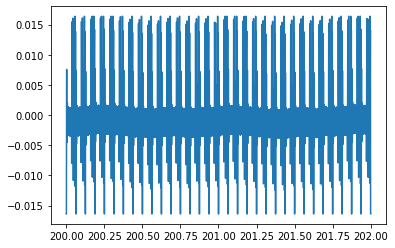

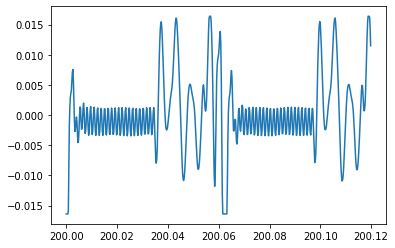

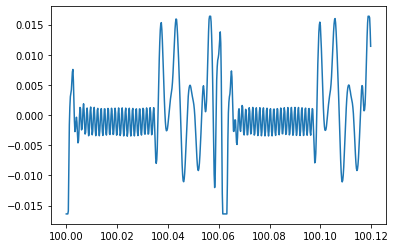

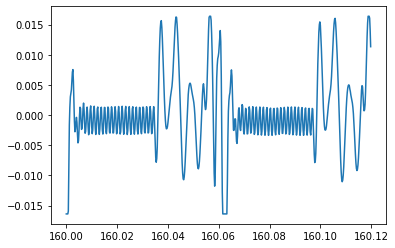

In [21]:
ecg_data = raw_data[ecg_channel_index,:]

print(raw_time)

plt.plot(raw_time, ecg_data )
plt.show()
plt.plot(raw_time[1000000:1010000], ecg_data[1000000:1010000])
plt.show()
plt.plot(raw_time[1000000:1000600], ecg_data[1000000:1000600])
plt.show()
i = 500000
plt.plot(raw_time[i:i+600], ecg_data[i:i+600])
plt.show()
i = 800000
plt.plot(raw_time[i:i+600], ecg_data[i:i+600])
plt.show()

**NB : Cela n'a pas vraiment la tête d'un AP (complexe QRS). Cela est sans doute du à la présence de l'artefact de gradient.**

Nous commençons donc par retirer l'artefact de gradient.

Soustraction de l'artéfact de gradient


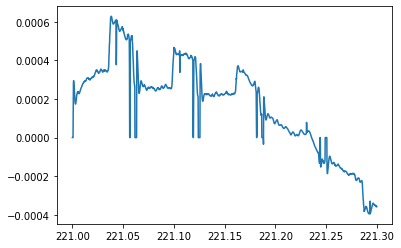

In [22]:
marker_period = get_gradient_artifact_marker_period(annotations)

cleaned_ecg_data,cleaned_time = clean_gradient(ecg_data, raw_time, 21, marker_period)


s=1000000
size = 1500
print("Soustraction de l'artéfact de gradient")
plt.plot(cleaned_time[s:s+size], cleaned_ecg_data[s:s+size])
plt.show()

Nous appliquons ensuite le sous-échantillonnage et le filtre passe-bas.

Signal ECG : 


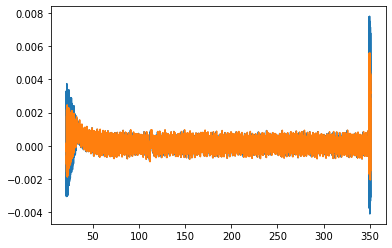

Zoom :


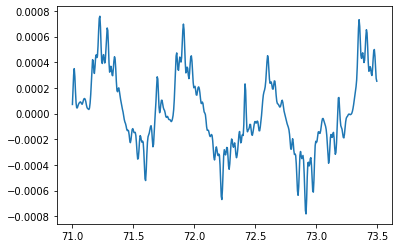

In [23]:
undersampled_ecg_data, undersampled_time, undersampled_freq = undersample(cleaned_ecg_data, cleaned_time, frequency = 5000, diminution_factor = 25)
low_passed_ecg_data = low_pass_filter(undersampled_ecg_data)
print("Signal ECG : ")
plt.plot(undersampled_time,undersampled_ecg_data)
plt.plot(undersampled_time,low_passed_ecg_data)
plt.show()

print("Zoom :")
start = 10000
size = 500
plt.plot(undersampled_time[start:start+size],low_passed_ecg_data[start:start+size])
plt.show()


L'objectif est alors d'y identifier les pics afin de récupérer les marqueurs de l'artefact de pouls. 

Nous pourrons ensuite obtenir sa forme en employant ces marqueurs sur le canal EEG de référence.

### Filtre passe-bas en moyenne glissante

Afin de réduire le bruit en haute fréquence, nous appliquons un filtre passe-bas en moyenne glissante sur 3 coefficients.

Signal filtré :


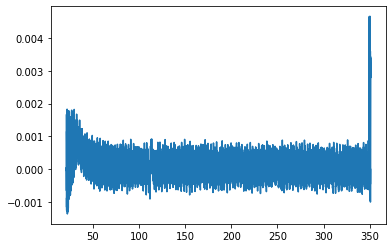

Zoom :


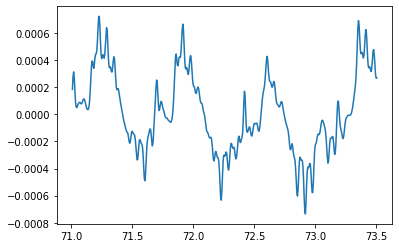

In [24]:
ecg_pulse_artifact = low_passed_ecg_data

low_passed_ecg_pulse_artifact = cumsum_sma(ecg_pulse_artifact, period = 3)
low_passed_ecg_time = undersampled_time[2:]

print("Signal filtré :")
plt.plot(low_passed_ecg_time, low_passed_ecg_pulse_artifact)
plt.show()
print("Zoom :")
start = 10000
size = 500
plt.plot(low_passed_ecg_time[start:start+size], low_passed_ecg_pulse_artifact[start:start+size])
plt.show()

### Filtre passe-haut à réponse impulsionnelle finie

Nous appliquons ensuite un filtre passe-haut afin de réduire l'effet des changements de référentiel de l'IRM. Ce filtre est à réponse impulsionnelle finie (sur 25 coefficients), avec une coupure à 20 Hz.

Nous employons à cette fin les fonctions **firwin**, du module *scipy.signal*, et **convolve**, du module *numpy*,, selon les scripts du [livre de recettes SciPy](https://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html). 

Signal filtré :


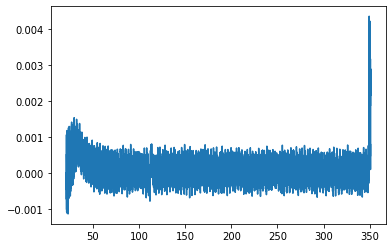

Zoom :


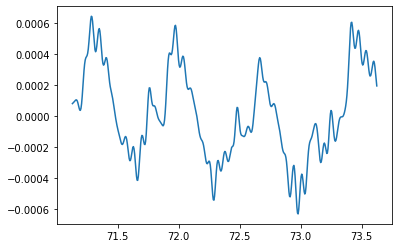

In [25]:
FIR_filter = signal.firwin(numtaps = 25, cutoff = 20, nyq = undersampled_freq/2.)

high_passed_ecg_pulse_artifact = np.convolve(low_passed_ecg_pulse_artifact, FIR_filter, mode='valid')
high_passed_ecg_time = low_passed_ecg_time[24:]

print("Signal filtré :")
plt.plot(high_passed_ecg_time, high_passed_ecg_pulse_artifact)
plt.show()
print("Zoom :")
start = 10000
size = 500
plt.plot(high_passed_ecg_time[start:start+size], high_passed_ecg_pulse_artifact[start:start+size])
plt.show()

Le signal est encore trop fluctuant pour y appliquer une simple détection de pics à seuil :

6206


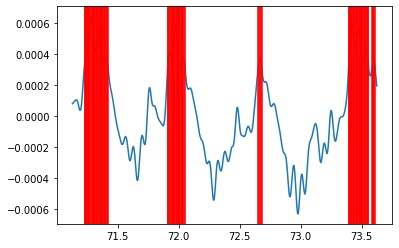

In [26]:
start_time = 20 #s
end_time = 240 #s
sfreq = undersampled_freq #Hz #raw.sfreq not working
start_index = int(start_time * sfreq)
end_index = int(end_time * sfreq)

threshold = 0.0003
peaks_indices = []

for i in range(start_index, end_index+1):
    #above_threshold = abs(high_passed_ecg_pulse_artifact[i]) > threshold
    above_threshold = high_passed_ecg_pulse_artifact[i] > threshold
    curve_inversion = (  (high_passed_ecg_pulse_artifact[i-1]-high_passed_ecg_pulse_artifact[i])
                        *(high_passed_ecg_pulse_artifact[i]-high_passed_ecg_pulse_artifact[i+1])) > 0
    if above_threshold and curve_inversion:
        peaks_indices.append(i)
        
print(len(peaks_indices))

s=10000
size = 500
plt.plot(high_passed_ecg_time[s:s+size], high_passed_ecg_pulse_artifact[s:s+size])
local_peaks_indices = [i for i in peaks_indices if (s<i and i<s+size)]
for i in local_peaks_indices:
    plt.axvline(high_passed_ecg_time[i], color ='red')
plt.show()

## Découpage de la fenêtre sur 10 secondes

Implémentons donc la méthode de l'[article](https://www.sciencedirect.com/science/article/abs/pii/S1053811998903615?via%3Dihub) de Allen et asso. de 1998 sur la soustraction de l'AP.

Elle consiste tout d'abord en un découpage du signal en fenêtres de 0.5s sur les 10 secondes précédentes.

**Non implémenté pour le moment, par simplicité !**

Les pics ne délimitent pas bien les artefacts; il y en a plusieur par pulsation.

Nous allons donc nettoyer ce tableau en éliminant les pics trop proches.

Par simplicité, nous allons regrouper les pics suffisamment proches, et conserver seulement le plus intense.

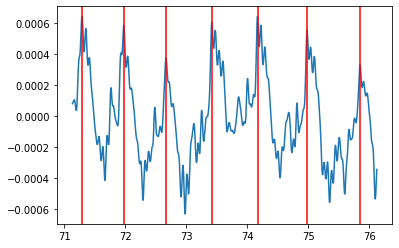

In [27]:
min_period = 0.3 #s
time = high_passed_ecg_time
data = high_passed_ecg_pulse_artifact

peaks_indices_group = [[peaks_indices[0]]]
for i in peaks_indices[1:]:
    last_index = peaks_indices_group[-1][-1]
    time_distance = time[i] - time[last_index]
    if time_distance < min_period:
        peaks_indices_group[-1].append(i)
    else:
        peaks_indices_group.append([i])

cleaned_peaks_indices = []
for indices_group in peaks_indices_group:
    max_index = indices_group[0]
    max_amplitude = data[max_index]
    for i in range(1, len(indices_group)):
        amplitude = data[indices_group[i]]
        if amplitude > max_amplitude:
            max_index = indices_group[i]
            max_amplitude = amplitude
    cleaned_peaks_indices.append(max_index)
    
s=10000
size = 1000
plt.plot(time[s:s+size], data[s:s+size])
local_cleaned_peaks_indices = [i for i in cleaned_peaks_indices if (s<i and i<s+size)]
for i in local_cleaned_peaks_indices:
    plt.axvline(time[i], color ='red')
plt.show()

Cela donne des résultats qui semblent corrects.

Retraduisons cela en marqueurs temporels.

In [28]:
pulse_artifact_markers = [peak_index/undersampled_freq for peak_index in cleaned_peaks_indices]
print(pulse_artifact_markers)

[20.275, 21.83, 22.595, 24.215, 25.1, 26.66, 27.42, 28.22, 28.975, 29.775, 30.535, 31.29, 32.095, 32.915, 33.715, 34.475, 35.275, 36.04, 36.78, 37.59, 38.35, 39.155, 39.905, 40.715, 41.535, 42.29, 43.09, 43.9, 44.72, 45.465, 46.28, 47.09, 47.965, 48.715, 49.465, 50.16, 50.84, 51.54, 52.285, 53.04, 53.855, 54.725, 55.48, 56.285, 57.095, 57.92, 58.66, 59.465, 60.275, 61.045, 61.84, 62.66, 63.48, 64.34, 65.155, 65.975, 66.85, 67.53, 68.35, 69.16, 69.905, 70.715, 72.285, 73.04, 73.85, 74.71, 75.53, 76.29, 77.1, 77.91, 78.72, 79.47, 80.275, 81.04, 81.775, 82.465, 83.155, 83.915, 84.715, 85.53, 86.41, 87.225, 88.04, 88.91, 91.905, 92.66, 93.59, 94.405, 95.285, 96.16, 96.98, 97.84, 98.535, 99.28, 100.035, 100.84, 101.59, 102.405, 103.225, 103.98, 104.785, 105.54, 106.35, 107.165, 107.975, 108.84, 109.66, 110.475, 111.285, 112.105, 112.965, 113.785, 114.6, 115.41, 116.21, 116.965, 117.72, 118.53, 119.345, 120.1, 120.905, 122.595, 123.475, 124.345, 125.1, 125.91, 126.715, 128.35, 129.215, 130.0

On obtient bien des marqueurs entre les temps de début et de fin, avec une simili-périodicité de l'ordre de la seconde. Il est à noter qu'il y a tout de même quelques différences avec les valeurs obtenues par MNE

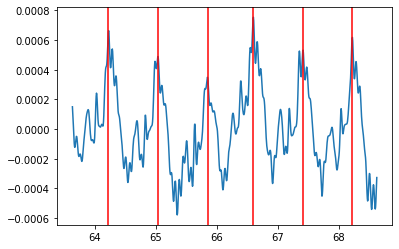

In [29]:
s=8500
size = 1000
time = high_passed_ecg_time
data = high_passed_ecg_pulse_artifact
freq = undersampled_freq
plt.plot(time[s:s+size], data[s:s+size])
local_pulse_artifact_markers = [t for t in pulse_artifact_markers if (s<t*freq and t*freq<s+size)]
for t in local_pulse_artifact_markers:
    #décalage dans t
    plt.axvline(time[0]+t, color ='red')
plt.show()

Retournons donc sur le signal EEG afin d'isoler le signal associé à l'artéfact de pouls.

In [30]:
print(raw.info)
print(raw.ch_names)
eeg_channel_index = 0
print(eeg_channel_index)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

[0.000000e+00 2.000000e-04 4.000000e-04 ... 3.508994e+02 3.508996e+02
 3.508998e+02]


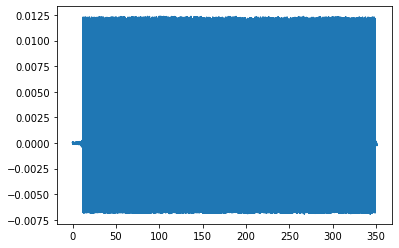

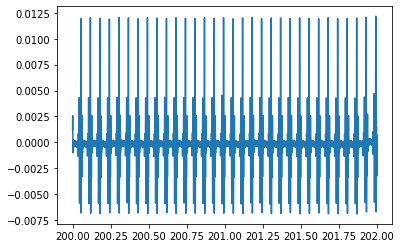

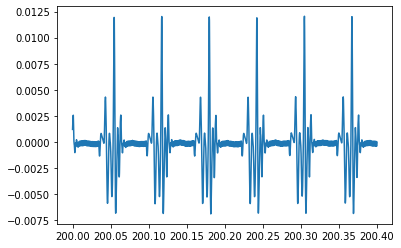

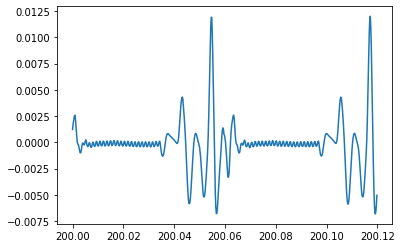

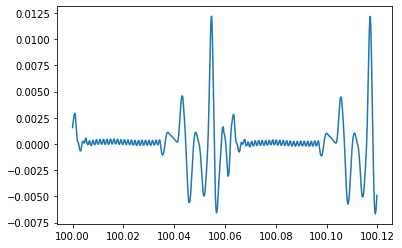

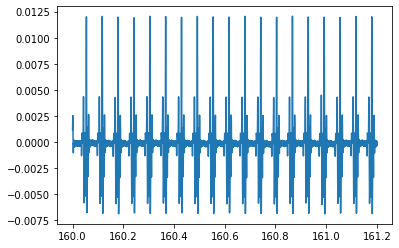

In [31]:
eeg_data = raw_data[eeg_channel_index,:]

print(raw_time)

plt.plot(raw_time, eeg_data )
plt.show()
plt.plot(raw_time[1000000:1010000], eeg_data[1000000:1010000])
plt.show()
plt.plot(raw_time[1000000:1002000], eeg_data[1000000:1002000])
plt.show()
plt.plot(raw_time[1000000:1000600], eeg_data[1000000:1000600])
plt.show()
i = 500000
plt.plot(raw_time[i:i+600], eeg_data[i:i+600])
plt.show()
i = 800000
plt.plot(raw_time[i:i+6000], eeg_data[i:i+6000])
plt.show()

On nettoie de nouveau l'artefact de gradient.

Soustraction de l'artéfact de gradient


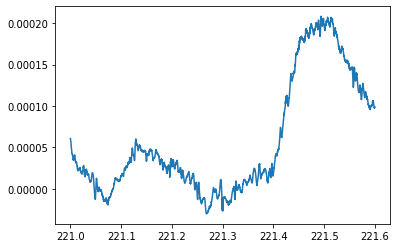

In [32]:
marker_period = get_gradient_artifact_marker_period(annotations)

cleaned_eeg_data,cleaned_time = clean_gradient(eeg_data, raw_time, 21, marker_period)


s=1000000
size = 3000
print("Soustraction de l'artéfact de gradient")
plt.plot(cleaned_time[s:s+size], cleaned_eeg_data[s:s+size])
plt.show()

On applique de même les précédents traitements.

Sous-échantillonnage + filtre passe-bas ;


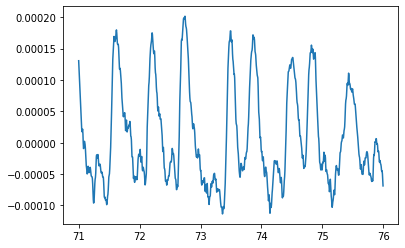

In [33]:
undersampled_eeg_signal, undersampled_eeg_time, undersampled_eeg_frequency = undersample(
            cleaned_eeg_data, 
            cleaned_time, 
            5000)
low_passed_eeg_signal = low_pass_filter(undersampled_eeg_signal, undersampled_eeg_frequency)
s=10000
size = 1000
print("Sous-échantillonnage + filtre passe-bas ;")
plt.plot(undersampled_eeg_time[s:s+size], low_passed_eeg_signal[s:s+size])
plt.show()

On peut alors créer un signal d'artefact de pouls, en faisant les moyennes cumulées des artefacts sur les 10 secondes précédentes. Nous avons cependant une difficulté supplémentaire par rapport à l'artéfact de gradient : cet artéfact n'est pas parfaitement régulier.

Arbitrairement, nous allons simplifier en ajustant, par troncature ou complétion à 0 les événements précédents.

Il est à noter que notre zone d'intérêt est centrée sur les pics détectés.

In [40]:
frequency = undersampled_eeg_frequency
delay = 0.3 #s

annotations = mne.read_annotations('../EEG_Data/pp1/S10_NF1_$pp1_new.vmrk')
ecg_time_markers =[annotation['onset'] for annotation in annotations if annotation['description'] == "Pulse Artifact/R"]
print(ecg_time_markers)
#delayed markers
real_time_markers = [m+delay for m in ecg_time_markers]
real_index_markers = [int(frequency * t) for t in real_time_markers]


Finding 'sfreq' from header file: ../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr
[0.175, 1.065, 1.845, 2.63, 3.395, 4.165, 4.96, 5.84, 6.72, 7.53, 8.47, 9.46, 10.31, 11.205, 12.1, 12.915, 13.735, 14.575, 15.4, 16.185, 16.995, 17.835, 18.65, 19.465, 20.295, 21.14, 21.91, 22.7, 23.47, 24.22, 25.015, 25.845, 26.65, 27.455, 28.275, 29.09, 29.845, 30.635, 31.435, 32.195, 32.96, 33.77, 34.59, 35.375, 36.135, 36.91, 37.705, 38.45, 39.22, 40.01, 40.805, 41.58, 42.37, 43.18, 43.96, 44.735, 45.53, 46.345, 47.1, 47.9, 48.75, 49.6, 50.37, 51.095, 51.79, 52.47, 53.195, 53.965, 54.71, 55.525, 56.385, 57.155, 57.96, 58.775, 59.585, 60.34, 61.135, 61.92, 62.715, 63.485, 64.28, 65.145, 65.965, 66.805, 67.63, 68.41, 69.19, 69.97, 70.795, 71.57, 72.375, 73.16, 73.95, 74.705, 75.51, 76.345, 77.155, 77.96, 78.76, 79.585, 80.355, 81.145, 81.92, 82.705, 83.405, 84.095, 84.8, 85.59, 86.37, 87.195, 88.035, 88.88, 89.705, 90.56, 91.4, 92.15, 92.965, 93.57, 94.29, 95.185, 96.05, 96.915, 97.785, 98.645, 99.465, 100.21, 10

In [41]:
frequency = undersampled_eeg_frequency
markers = real_index_markers
#markers = index_markers

mean_RR_size = int(np.mean([(markers[i+1]-markers[i]) for i in range(len(markers)-1)]))
mean_RR_time = mean_RR_size / frequency
half_RR = mean_RR_size//2
print("Mean RR time:",mean_RR_time)
print("Mean RR size:",mean_RR_size)
print("Half RR size:",half_RR)

print(np.mean([[1,1,1],[2,2,2]], axis = 0))
print(np.amax([[1,1,1],[2,2,2]], axis = 1))

Mean RR time: 0.825
Mean RR size: 165
Half RR size: 82
[1.5 1.5 1.5]
[1 2]


2040 2204 0.0002461657453409035
2219 2383 0.00015036827710051168
2398 2562 0.00017500209496550042
2561 2725 0.00014866525571063496
2725 2889 0.0001243609185056601
2893 3057 0.0001604789203026346
3058 3222 -2.6085922617169893e-05
3215 3379 -1.599136222343023e-05
3377 3541 0.00012842936442276307
3545 3709 0.00016661212471243345
3708 3872 0.00018829710320721779
3871 4035 -3.365000057627219e-05
4037 4201 0.00015883383312742197
4206 4370 7.97102090766216e-05
4360 4524 0.00011943939069924721
4518 4682 0.0001806464830075322
4672 4836 0.00018808454947190952
4822 4986 0.00016175945778103623
4981 5145 6.875290556410972e-05
5147 5311 0.0002196499940189717
5308 5472 -3.2938387381475356e-06
5469 5633 0.00019179335331973005
5633 5797 4.6334630355059526e-05
5796 5960 0.00020561093719298205
5947 6111 0.00016721452965861992
6105 6269 1.8631098809391985e-05
6265 6429 2.3565019331032037e-05
6416 6580 3.0901228965580404e-05
6570 6734 0.00017470835864181832
6732 6896 1.80343013765055e-05
6896 7060 0.000216

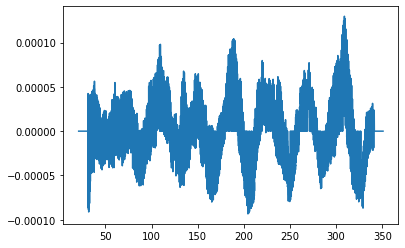

Zoom on a detected peak time :


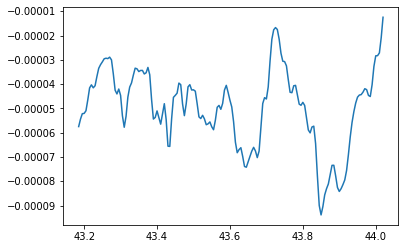

Zoom :


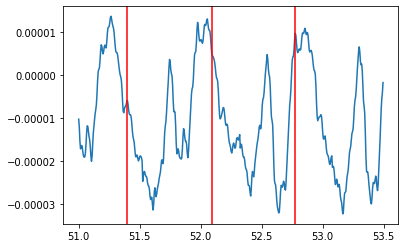

Zoom :


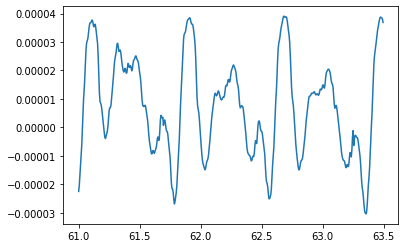

Zoom :


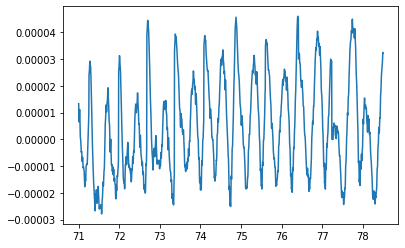

In [43]:
full_signal = low_passed_eeg_signal

comparison_max_length = 10*frequency #s * Hz
#print(comparison_max_length)

averaged_signal = np.zeros((len(full_signal,)))

RR_intervals = [(marker-half_RR, marker+half_RR)
                            for marker in markers if marker-half_RR >= 0]
#print(RR_intervals)

relevant_intervals = [interval for interval in RR_intervals
                            if interval[0] > comparison_max_length] #RR_intervals[0][0] +

#print(relevant_intervals)


for (i,j) in relevant_intervals:
    print(i,j, max(full_signal[i:j]))


#print(len(relevant_intervals))
#print(np.array([np.amax([full_signal[i:j] for (i,j) in relevant_intervals], axis =1)]).shape)
#print(np.array([np.amax([full_signal[i:j] for (i,j) in relevant_intervals], axis =1)]))
#print("Average peak height", np.mean([np.amax([full_signal[i:j] for (i,j) in relevant_intervals], axis = 1)]))
#print("Lowest peak height", np.amin([np.amax([full_signal[i:j] for (i,j) in relevant_intervals], axis = 1)], axis = 0),
#      "at index", np.argmin([np.amax([full_signal[i:j] for (i,j) in averaging_intervals], axis = 1)],axis = 0) )

for (start_index,end_index) in relevant_intervals:
    #print(start_index,end_index)
    #print("Real max", max(full_signal[start_index:end_index]),"Averaged max",max(average_interval))
    averaging_intervals = [interval for interval in RR_intervals
                                    #the end of the interval is above the 10s preceding the interest interval's start.
                                    if interval[-1] > start_index - comparison_max_length
                                    #the end of the interval is before the interest interval's one.
                                    and interval[-1] <= end_index]
    average_interval = np.mean([full_signal[i:j] for (i,j) in averaging_intervals], axis=0)
    #print(averaging_intervals)
    #print(np.array([full_signal[i:j] for (i,j) in averaging_intervals]).shape)
    #print(average_interval.shape)
    
    averaged_signal[start_index:end_index] = average_interval
    
averaged_pa_signal = averaged_signal
print("Averaged average peak height", np.mean([np.amax([averaged_pa_signal[i:j] for (i,j) in averaging_intervals], axis = 1)]))

print("Signal d'artefact de pouls complet :")
plt.plot(undersampled_eeg_time, averaged_pa_signal)
plt.show()

s = 4437
size = 168
print("Zoom on a detected peak time :")
plt.plot(undersampled_eeg_time[s:s+size], full_signal[s:s+size])
plt.show()

s=6000
size = 500
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.axvline(real_time_markers[63], color = "red")
plt.axvline(real_time_markers[64], color = "red")
plt.axvline(real_time_markers[65], color = "red")
plt.show()

s=8000
size = 500
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.show()
s=10000
size = 1500
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.show()

In [ ]:
import numpy as np

#tested
def average(arrays, average_size):
    mean_array = [np.mean([array[i] for array in arrays if len(array) > i])
                      for i in range(average_size)]
    return mean_array
 
frequency = 200 #Hz
index_markers = [int(frequency*t) for t in pulse_artifact_markers]

comparison_max_delay = 10*frequency #s * Hz
markers = index_markers
full_signal = low_passed_eeg_signal

averaged_signal = np.zeros((len(full_signal,)))



relevant_intervals = [(markers[i],markers[i+1])
                                    for i in range(len(markers)-1)
                                     if markers[i+1] > comparison_max_delay]

for (start_index,end_index) in relevant_intervals:
    print("Real max", max(full_signal[start_index:end_index]),"Averaged max",max(average_interval))
    averaging_intervals = [interval for interval in relevant_intervals
                                    #the end of the interval is above the 10s preceding the interest interval's start.
                                    if interval[-1] > start_index - comparison_max_delay
                                    #the end of the interval is before the interest interval's one.
                                    and interval[-1] <= end_index]
    #print("Abnormal:",len(averaging_intervals),"intervals. (should be around 10)")
    #print(averaging_intervals)
    average_interval_size = end_index - start_index
    average_interval = average([full_signal[i:j] for (i,j) in averaging_intervals], average_interval_size)
    averaged_signal[start_index:end_index] = average_interval

    
averaged_pa_signal = averaged_signal
print("Signal d'artefact de pouls complet :")
plt.plot(undersampled_eeg_time, averaged_pa_signal)
plt.show()
s=6000
size = 500
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.show()
s=8000
size = 500
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.show()
s=10000
size = 3000
print("Zoom :")
plt.plot(undersampled_eeg_time[s:s+size], averaged_pa_signal[s:s+size])
plt.show()

On observe une périodicité remarquable, malgré de très légères variations.

Nous en faisons une fonction pour plus tard.

In [ ]:
def average(arrays, average_size):
    mean_array = [np.mean([array[i] for array in arrays if len(array) > i])
                      for i in range(average_size)]
    return mean_array

def get_pulse_artifact_signal(full_signal, markers, comparison_max_delay = 10*200):
    averaged_signal = np.zeros((len(full_signal,)))

    relevant_intervals = [(markers[i],markers[i+1])
                                    for i in range(len(markers)-1)
                                     if markers[i+1] > comparison_max_delay]

    for (start_index,end_index) in relevant_intervals:
        averaging_intervals = [interval for interval in relevant_intervals
                                    if interval[-1] > start_time - comparison_max_delay]
    
        average_interval_size = end_index - start_index
        average_interval = average([full_signal[i:j] for (i,j) in averaging_intervals], average_interval_size)
        averaged_signal[start_index:end_index] = average_interval

    return averaged_signal

### Soustraction aux autres signaux

Nous pouvons donc soustraire ce signal d'artefact aux autres signaux, notamment au signal EP1 du début.

In [ ]:
data = low_passed_eeg_signal
time = resampled_time

print(data.shape, averaged_pa_signal.shape)

pa_cleaned_eeg_signal = data - averaged_pa_signal



print("Signaux avec et sans artefact de pouls")
plt.plot(resampled_time, data, color = "blue") 
plt.plot(resampled_time, pa_cleaned_eeg_signal, color = "orange")
plt.show()

print("Zoom")
s=6000
size = 2000
plt.plot(resampled_time[s:s+size], data[s:s+size], color = "blue")
plt.plot(resampled_time[s:s+size], pa_cleaned_eeg_signal[s:s+size], color = "orange")
plt.show()

print("Zoom")
s=10000
size = 3000
plt.plot(resampled_time[s:s+size], data[s:s+size], color = "blue")
plt.plot(resampled_time[s:s+size], pa_cleaned_eeg_signal[s:s+size], color = "orange")
plt.show()

# ANCIENS ESSAIS 

In [ ]:
start_time = 20 #s
end_time = 240 #s
sfreq = 5000 #Hz #raw.sfreq not working
start_index = start_time * sfreq
end_index = end_time * sfreq

threshold = 0.015
peaks_indices = []

for i in range(start_index, end_index+1):
    above_threshold = abs(ecg_data[i]) > threshold
    curve_inversion = (ecg_data[i-1]-ecg_data[i])*(ecg_data[i]-ecg_data[i+1]) > 0
    if above_threshold and curve_inversion:
        peaks_indices.append(i)
        
print(len(peaks_indices))

s=1000000
size = 750
plt.plot(raw_time[s:s+size], ecg_data[s:s+size])
local_peaks_indices = [i for i in peaks_indices if (s<i and i<s+size)]
for i in local_peaks_indices:
    plt.axvline(raw_time[i], color ='red')
plt.show()

Les pics ne délimitent pas bien les artefacts; il y en a plusieur par pulsation.

Nous allons donc nettoyer ce tableau en éliminant les pics trop proches.

Par simplicité, nous allons regrouper les pics suffisamment proches, et conserver seulement le plus intense.

In [ ]:
min_period = 0.02 #s
peaks_indices_group = [[peaks_indices[0]]]
for i in peaks_indices[1:]:
    last_index = peaks_indices_group[-1][-1]
    time_distance = raw_time[i] - raw_time[last_index]
    if time_distance < min_period:
        peaks_indices_group[-1].append(i)
    else:
        peaks_indices_group.append([i])

cleaned_peaks_indices = []
for indices_group in peaks_indices_group:
    max_index = indices_group[0]
    max_amplitude = ecg_data[max_index]
    for i in range(1, len(indices_group)):
        amplitude = ecg_data[indices_group[i]]
        if amplitude > max_amplitude:
            max_index = indices_group[i]
            max_amplitude = amplitude
    cleaned_peaks_indices.append(max_index)
    
s=1000000
size = 1500
plt.plot(raw_time[s:s+size], ecg_data[s:s+size])
local_cleaned_peaks_indices = [i for i in cleaned_peaks_indices if (s<i and i<s+size)]
for i in local_cleaned_peaks_indices:
    plt.axvline(raw_time[i], color ='red')
plt.show()

# ANCIENS ESSAIS

Cela vérifié, nous pouvons moyenner point par point.

**NOTA BENE : à refaire avec une moyenne glissante**

In [ ]:
artifacts_signals = np.array([ep1_raw_data[
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[0]:
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[1]
    
                                          ] 
                              for annotation in response_annotations])

mean_artifact_signal = np.mean(artifacts_signals, axis = 0)
time_reference = np.arange(0, len(mean_artifact_signal))/len(mean_artifact_signal)*artifact_duration

plt.plot(time_reference, mean_artifact_signal)
plt.show()

print(mean_artifact_signal.shape,ep1_raw_data.shape)
print(artifacts_signals[0].shape)

Nous pouvons ensuite soustraire cette forme au signal original au niveau des artéfacts.

In [ ]:
for annotation in response_annotations:
    artifact_time_interval = ([annotation['onset'], 
                               annotation['onset']+annotation['duration']])
    artifact_start_frame, artifact_end_frame = raw.time_as_index(artifact_time_interval)
    
    
    print(artifact_time_interval)
    print(artifact_start_frame, artifact_end_frame)
    print(ep1_raw_data[ artifact_start_frame : artifact_end_frame ])
    ep1_raw_data[ artifact_start_frame : artifact_end_frame ]-= mean_artifact_signal